In [29]:
import logging
logger = logging.getLogger()
for handler in logger.handlers:
    handler.level = logging.WARNING
handler = logging.FileHandler(filename='eit.log', mode='w')
handler.level = logging.INFO
logger.level = logging.INFO
logger.addHandler(handler)

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
import matplotlib
from mcmc import pcn
%load_ext mcmc
%mcmc notebook
import scipy
from scipy import stats
import tables
#import gpanim
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [31]:
bayesian_approach = True
use_real_data = False
dest_name = '/Volumes/My Passport/samples_real_coll.h5'

In [32]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)

In [33]:
seed = 124
np.random.seed(seed)

In [34]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')

In [35]:
# load in observational data
current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')
if use_real_data:
    voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000r.txt')
    #voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006r.txt') # empty tank
else:
    voltage_file = np.loadtxt('sim_data/voltages.txt')


experiments = []
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages = voltage_file[32*i+1:32*(i+1)+1]
    experiments.append((this_currents.reshape((32,1)), this_voltages.reshape((32,1))))

# Set Up Design Points

In [36]:
# there are 32 evenly spaced electrodes between 0 and 2\pi
# the electrodes go counter-clockwise from the +x axis and finish at x=1, y=0
electrodes = np.linspace(0, 2*np.pi, 33)[1:-1]
electrodes = np.append(electrodes,0)
electrode_x = np.cos(electrodes)
electrode_y = np.sin(electrodes)

bdy = np.c_[electrode_x, electrode_y]

In [37]:
# we also need a few interior points
radii = np.linspace(0,1,11)[1:-1]
r_spacing = radii[1] - radii[0]
coords = [np.array([[0.,0.]])]
for r in radii:
    # we want the number of theta which 
    n_theta = np.round(2*np.pi*r / r_spacing)
    thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
    x = np.cos(thetas)
    y = np.sin(thetas)
    coords.append(r*np.c_[x,y])
coords = np.concatenate(coords)

interior = coords

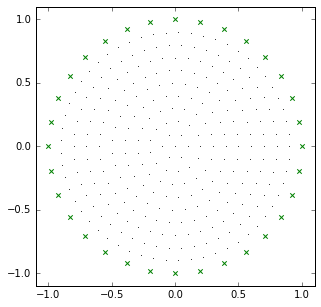

In [38]:
plt.figure(figsize=(5,5))
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
plt.scatter(bdy[:,0], bdy[:,1], marker='x', c='green')
plt.scatter(interior[:,0], interior[:,1], linewidth=0, c='black', s=1)

In [39]:
obs = [(interior, None), (bdy, None)]
interior_obs = np.zeros((interior.shape[0], 1))

In [40]:
field_pts = np.r_[interior, bdy]
n_field = len(field_pts)
def vec_to_kappas(vec):
    return vec[:n_field, None], vec[n_field:2*n_field, None], vec[2*n_field:, None]

# Construct the Model

In [41]:
length_scale = sp.Symbol('sigma')
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))

# Operators in the expanded version of the problem
A_1 = NamedLambda(lambda k: k.diff(x_1), 'A_1')
A_2 = NamedLambda(lambda k: k.diff(x_2), 'A_2')
A_3 = NamedLambda(lambda k: k.diff(x_1, x_1) + k.diff(x_2, x_2), 'A_3')
A_1_bar = NamedLambda(lambda k: k.diff(y_1), 'A_1_bar')
A_2_bar = NamedLambda(lambda k: k.diff(y_2), 'A_2_bar')
A_3_bar = NamedLambda(lambda k: k.diff(y_1, y_1) + k.diff(y_2, y_2), 'A_3_bar')

# Transformed operators
A_t = 'A_t'
A_bar_t = 'A_bar_t'

# Boundary operators
B = NamedLambda(lambda k: (k.diff(x_1)*x_1 + k.diff(x_2)*x_2), 'B')
B_bar = NamedLambda(lambda k: (k.diff(y_1)*y_1 + k.diff(y_2)*y_2), 'B_bar')

# Transformed boundary operators
B_t = 'B_t'
B_bar_t = 'B_bar_t'

ops = [A_t, B_t]
ops_bar = [A_bar_t, B_bar_t]

ops_base = [A_1, A_2, A_3, B]
ops_bar_base = [A_1_bar, A_2_bar, A_3_bar, B_bar]
op_cache_base = bpdes.operator_compilation.compile_sympy(ops_base, ops_bar_base, k_sqexp, [[x_1, x_2], [y_1, y_2], length_scale])

In [42]:
arg_caching = bpdes.operator_compilation.CachingOpCache(op_cache_base)

In [62]:
from __future__ import print_function
class TransformedOpCache(object):
    def __init__(self, op_cache, kappa, grad_kappa_x, grad_kappa_y, verbosity=0):
        self.__op_cache__ = op_cache
        self.__kappa__ = kappa
        self.__grad_kappa_x__ = grad_kappa_x
        self.__grad_kappa_y__ = grad_kappa_y
        self.__verbosity__ = verbosity
    
    def __getitem__(self, item):
        return do_transform(item, self.__op_cache__, self.__kappa__, self.__grad_kappa_x__, self.__grad_kappa_y__, self.__verbosity__)

def do_transform(item, op_cache, kappa, grad_kappa_x, grad_kappa_y, verbosity):
    def printer(*args):
        if verbosity > 0:
            print(*args)
    exp_kappa = np.exp(kappa.reshape((len(kappa), 1)))
    exp_kappa_int = exp_kappa[:len(interior),:]
    exp_kappa_bdy = exp_kappa[len(interior):,:]
    grad_kappa_x = grad_kappa_x[:len(interior)].reshape((len(interior),1))
    grad_kappa_y = grad_kappa_y[:len(interior)].reshape((len(interior),1))
    all_things = [()]
    
    # first explode out the objects required
    for i in item:
        if i == A_t:
            all_things = sum([[a + (A_1,), a + (A_2,), a + (A_3,)] for a in all_things], [])
        elif i == A_bar_t:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,), a + (A_3_bar,)] for a in all_things], [])
        elif i == B_t:
            all_things = [a + (B,) for a in all_things]
        elif i == B_bar_t:
            all_things = [a + (B_bar,) for a in all_things]
        else:
            all_things = [a + (i,) for a in all_things]
    printer('Mapped {} to {}'.format(item, all_things))

    def __calc_result(x,y,fun_args=None):
        if fun_args is None:
            fun_args = []
        result = 0
        for item in all_things:
            try:
                function = op_cache[item]
            except Exception as ex:
                printer('Failed to get {}'.format(item))
                raise ex
            new_mat = function(x,y,fun_args)
            
            # unbarred
            if A_1 in item:
                printer('Transforming A_1')
                new_mat = np.repeat(grad_kappa_x*exp_kappa_int,y.shape[0],1) * new_mat
            elif A_2 in item:
                printer('Transforming A_2')
                new_mat = np.repeat(grad_kappa_y*exp_kappa_int,y.shape[0],1) * new_mat
            elif A_3 in item:
                printer('Transforming A_3')
                new_mat = np.repeat(exp_kappa_int,y.shape[0],1) * new_mat
                
            # barred
            if A_1_bar in item:
                printer('Transforming A_1_bar')
                new_mat = np.repeat(grad_kappa_x.T*exp_kappa_int.T,x.shape[0],0) * new_mat
            elif A_2_bar in item:
                printer('Transforming A_2_bar')
                new_mat = np.repeat(grad_kappa_y.T*exp_kappa_int.T,x.shape[0],0) * new_mat
            elif A_3_bar in item:
                printer('Transforming A_3_bar')
                new_mat = np.repeat(exp_kappa_int.T,x.shape[0],0) * new_mat
                
            # boundary
            if B in item:
                printer('Transforming B')
                new_mat = np.repeat(exp_kappa_bdy, y.shape[0], 1) * new_mat
            if B_bar in item:
                printer('Transforming B_bar')
                new_mat = np.repeat(exp_kappa_bdy.T, x.shape[0], 0) * new_mat
            result += new_mat
        return result
    return __calc_result

In [63]:
def plot_conductivity(thetas):
    sig_expr = get_c(x_1, x_2).subs({t: v for t,v in zip(ts, thetas)})
    sigma_field = sp.lambdify([x_1, x_2], sig_expr)
    res = np.vectorize(sigma_field)(test_x, test_y)
    plot_circle(test_x, test_y, res)
    
def plot_circle(x, y, values):
    plt.figure(figsize=(8,8))
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel())
    #colors = plt.contourf(test_x, test_y, mu_shaped,  250)
    plt.colorbar()
    plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
    plt.gcf().patch.set_alpha(0.0)

In [64]:
# now need to construct the thingy we are proposing over.
# Put a basis function at each point in the domain and iterate over them

# jointly proposing over the function and its derivatives wrt x and y.
# ironically constructing this is very similar to constructing our kernel matrix
Identity = lambda k: k
d1 = lambda k: k.diff(x_1)
d2 = lambda k: k.diff(x_2)
d1_bar = lambda k: k.diff(y_1)
d2_bar = lambda k: k.diff(y_2)

proposal_op_cache = bpdes.operator_compilation.compile_sympy([Identity, d1, d2], 
                                                             [Identity, d1_bar, d2_bar], 
                                                             k_sqexp, 
                                                             [[x_1, x_2], [y_1, y_2], [length_scale]]
                                                            )


In [65]:
# is there a units issue with normalising voltage here?
true_x = bdy
kappa_0 = np.zeros((n_field*3, 1))
currents = [e[0] for e in experiments]
voltages = [e[1] for e in experiments]
#volt_mean = np.asarray(voltages).mean()
#volt_std = np.asarray(voltages).std()
volt_mean = 0.
volt_std = 1.

In [69]:
def potential(proposal, length_scale):
    # potential is the negative log-likelihood
    return -log_likelihood(proposal, length_scale)

def log_likelihood(proposal, length_scale):
    # ugly and dirty and horrid
    kappa, kappa_x, kappa_y = vec_to_kappas(proposal)
    
    oc = TransformedOpCache(arg_caching, kappa, kappa_x, kappa_y, 0)
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=[np.array([length_scale])])
    mu_mult, cov = posterior.no_obs_posterior(true_x)
    cov_with_error = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    
    if bayesian_approach:
        like_dist = stats.multivariate_normal(np.zeros(cov.shape[0]), cov_with_error, False)
    
    ret = 0
    try:
        for c, v in zip(currents, voltages):
            g = np.concatenate([interior_obs, c])
            true_u = v.reshape((len(v), 1))
            mu = mu_mult.dot(g).reshape(true_u.shape)

            # todo: some inefficiency here - inverting cov multiple times
            if bayesian_approach:
                this_lik = like_dist.logpdf(true_u.ravel() - mu.ravel())
            else:
                this_lik = -(mu - true_u).T.dot(mu - true_u) / (2*likelihood_sigma**2)
            ret += this_lik
    except:
        return -np.inf
    return ret

In [70]:
likelihood_sigma = 1e-4

In [71]:
potential(kappa_0, 0.2)

In [73]:
#tmp = scipy.optimize.minimize(np.vectorize(lambda x: potential(kappa_0, x)), 0.2, method='Nelder-Mead')
#ls_ml = tmp.x
#print(ls_ml)

In [76]:
ls_ml = np.array([0.2])

In [77]:
kern_mat = bpdes.collocation.calc_LLbar([Identity, d1, d2], 
                                        [Identity, d1_bar, d2_bar], 
                                        proposal_obs, 
                                        proposal_op_cache, 
                                        fun_args=[ls_ml]
                                       )

In [78]:
n_iter = 2000000
storage_dump_interval = int(1e3)
beta = 5e-5

In [42]:
from mcmc import storage
with storage.DiskBackedStorage((storage_dump_interval, n_field*3), dest_name) as st:
    proposal = pcn.proposal(beta, kern_mat)
    _, acceptances = pcn.pCN(n_iter, proposal, lambda k: potential(k, ls_ml), kappa_0, storage=st)

import tables
with tables.open_file(dest_name, 'a') as tab:
    tab.create_group('/', 'params')
    tab.create_array('/params', 'beta', obj=beta)
    tab.create_array('/params', 'length_scale', obj=ls_ml)
    tab.create_array('/params', 'proposal_matrix', obj=kern_mat)
    tab.create_array('/params', 'locations', obj=field_pts)
    tab.create_array('/', 'acceptances', acceptances)

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/autograd/numpy/numpy_wrapper.py:54: UserWarning: r_ is slow for array inputs. np.concatenate() is faster.
  "np.concatenate() is faster.".format(slow_op_name))
/Users/benorn/Coding/mcmc/mcmc/pcn.py:74: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(cur_phi-new_phi))
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [53]:
import tables
with tables.open_file(dest_name) as tab:
    tmp = tab.get_node('/samples')
    thinned_burned = tmp[1000000::100]

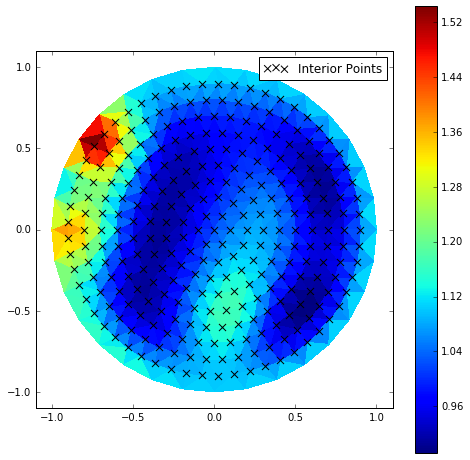

In [54]:
actual = np.mean(thinned_burned, axis=0)

plot_circle(field_pts[:,0], field_pts[:,1], np.exp(actual[:len(field_pts)]))

# Dummy diffusivity field

In [45]:
ls_ml = np.array([0.2])

In [46]:
true_kappa = sp.exp(-((x_1 - 0.4)**2 + (x_2 - 0.4)**2) / (2*0.2**2)) + sp.exp(-((x_1 + 0.4)**2 + (x_2 + 0.4)**2) / (2*0.2**2))
true_kappa_dx1 = true_kappa.diff(x_1)
true_kappa_dx2 = true_kappa.diff(x_2)

true_kappa_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa))
true_kappa_dx1_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx1))
true_kappa_dx2_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx2))

In [47]:
true_k = np.log(true_kappa_fun(field_pts[:,0], field_pts[:,1]))
true_k_x = true_kappa_dx1_fun(field_pts[:,0], field_pts[:,1])
true_k_y = true_kappa_dx2_fun(field_pts[:,0], field_pts[:,1])
true_fun = np.r_[true_k, true_k_x, true_k_y]

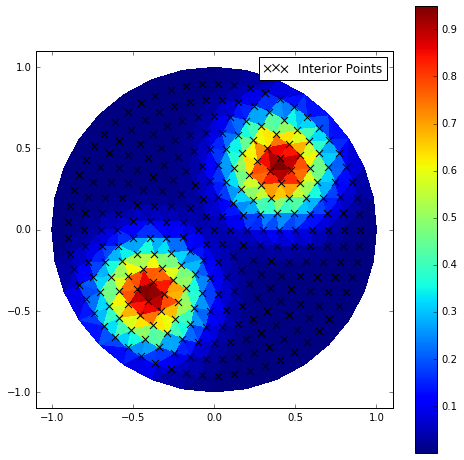

In [48]:
plot_circle(field_pts[:,0], field_pts[:,1], np.exp(true_k))

In [49]:
true_currents = [e[0] for e in experiments]
true_voltages = []
oc = TransformedOpCache(op_cache_base, true_k, true_k_x, true_k_y)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=[ls_ml])
mu_mult, cov = posterior.no_obs_posterior(true_x)
for c in true_currents:
    g = np.concatenate([interior_obs, c])
    mu = mu_mult.dot(g)
    true_voltages.append(mu)

In [50]:
voltage_file = np.concatenate([np.array([[0]])] + true_voltages)
np.savetxt('sim_data/voltages.txt', voltage_file)
np.savetxt('sim_data/truth.txt', np.c_[np.repeat(field_pts, 3, 0), true_fun[:,None]])